SIDE NOTE: would love to get any critiques, hints, tips, oberservations on any level not just on ML (but obviously ML as the priority).  Beginner Python learner (though I took the Full Stack Course) so any suggestions there are welcome.  Thanks.

Will need to import these libs plus setting some global variables

In [1]:
import sys
import os
import numpy as np
import renders as rs
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.externals import joblib
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import SVC
import matplotlib.cm as cm
# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Might need to change the path of the included libraries.
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/match_stats.py')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/form_model.py')
sys.path.append('/anaconda/envs/stats/lib/python3.5/site-packages')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/model_libs.py')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats/form_data.py')
sys.path.append('/Users/senzari/Machine_Learning/stats')
sys.path.append('/Users/senzari/Machine_Learning/stats/src/stats')
# print(sys.path)
os.chdir('/Users/senzari/Machine_Learning/stats/src')
#print(os.getcwd())

from stats import form_data, match_stats, model_libs, form_model, predict_matches

# Variables
round_number = 27 # for MLS only
target_col = 'points'
ignore_cols = ['match_id', 'team_id', 'team_name', 'opp_id', 'opp_name', 'scheduled', 'games_played', 'round']
sub_cols = ['current_formation', 'avg_goals_against', 'goal_diff', 'win_percentage', 'sos',
           'opp_win_percentage', 'opp_sos', 'current_team_yellow_cards', 'current_team_corner_kicks', 'current_team_first_half_goals', 'current_team_sec_half_goals', 
           'opp_team_yellow_cards', 'opp_team_corner_kicks', 'opp_team_first_half_goals', 'opp_team_sec_half_goals']

all_models = ['log', 'svc', 'gmm', 'knn', 'gnb']

""" this variable 'testing' should be false if using CSV's and not pulling from the database. """
testing = False

INITIALIZED...


Pulling in the data either from the Database or the CSV (CSV for testers).  Data has some added features in between the database and 'raw_data'.  Essentially trying 3 different versions of the data in this set.  One version contains all the features.  Another version has the standard features plus the calculated features of the home/away stats for a matchup.  The last version has the standard features plus the 'extended features' which not only includes the stats of the two teams in the match up but also the current teams previous opponents and the current teams opponents of the team opponents in that matchup.

In [2]:
data_csv = 'round' + str(round_number) + '.csv'

if testing:
    raw_data = form_data.run_data()
    raw_data.to_csv(data_csv)
    print("Raw Data Saved to CSV")
else:
    #Reading in a CSV adds the first index column
    raw_data = pd.read_csv(data_csv)
    raw_data = raw_data.drop(raw_data.columns[[0]], axis=1)

pd.set_option("display.max_columns", 85)

print('Data Loaded...')

ROUND 4 :: TEAM ID 21
ROUND 5 :: TEAM ID 21
ROUND 6 :: TEAM ID 21
ROUND 7 :: TEAM ID 21
ROUND 8 :: TEAM ID 21
ROUND 9 :: TEAM ID 21
ROUND 10 :: TEAM ID 21
ROUND 11 :: TEAM ID 21
ROUND 12 :: TEAM ID 21
ROUND 13 :: TEAM ID 21
ROUND 14 :: TEAM ID 21


/Users/senzari/.local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


ROUND 15 :: TEAM ID 21
ROUND 16 :: TEAM ID 21
ROUND 18 :: TEAM ID 21
ROUND 19 :: TEAM ID 21
ROUND 21 :: TEAM ID 21
ROUND 23 :: TEAM ID 21
ROUND 24 :: TEAM ID 21
ROUND 25 :: TEAM ID 21
ROUND 26 :: TEAM ID 21
ROUND 5 :: TEAM ID 22
ROUND 6 :: TEAM ID 22
ROUND 7 :: TEAM ID 22
ROUND 8 :: TEAM ID 22
ROUND 9 :: TEAM ID 22
ROUND 10 :: TEAM ID 22
ROUND 11 :: TEAM ID 22
ROUND 12 :: TEAM ID 22
ROUND 13 :: TEAM ID 22
ROUND 15 :: TEAM ID 22
ROUND 16 :: TEAM ID 22
ROUND 18 :: TEAM ID 22
ROUND 19 :: TEAM ID 22
ROUND 21 :: TEAM ID 22
ROUND 22 :: TEAM ID 22
ROUND 23 :: TEAM ID 22
ROUND 24 :: TEAM ID 22
ROUND 25 :: TEAM ID 22
ROUND 26 :: TEAM ID 22
ROUND 5 :: TEAM ID 23
ROUND 6 :: TEAM ID 23
ROUND 7 :: TEAM ID 23
ROUND 8 :: TEAM ID 23
ROUND 9 :: TEAM ID 23
ROUND 10 :: TEAM ID 23
ROUND 11 :: TEAM ID 23
ROUND 12 :: TEAM ID 23
ROUND 13 :: TEAM ID 23
ROUND 14 :: TEAM ID 23
ROUND 15 :: TEAM ID 23
ROUND 16 :: TEAM ID 23
ROUND 17 :: TEAM ID 23
ROUND 18 :: TEAM ID 23
ROUND 19 :: TEAM ID 23
ROUND 21 :: TEAM ID 2

## Training

Functions that trains basic models (and saves them if need be).  'load_models' will  load exisiting models to save time in testing.

In [3]:
# Removes Columns to Ignore and Splits the Target Column
def split_target(data):
    td = model_libs._clone_and_drop(data, ignore_cols)
    (y, X) = model_libs._extract_target(td, target_col)
    return X, y

"""No Cross-Validation and No Tuning"""
def train_models(round_num, X, y, models):
    
    if os.path.isdir("/models/" + str(round_num)):
        print('Making New Directory for the Round')
        os.chdir('/Users/senzari/Machine_Learning/stats/src/models')
        os.makedirs(str(round_num))
        os.chdir('/Users/senzari/Machine_Learning/stats/src')
        
    finished_models = []
    
    for i in models:
        
        model_round = 'models/' + str(round_num) + '/' + str(i) + '_round_' + str(round_num) + '.pk1'
        
        
        if i == 'log':
            log = form_model.build_model(X, y, i)
            joblib.dump(log, model_round)
            finished_models.append(log)
        elif i == 'svc':
            svc = form_model.build_model(X, y, i)
            joblib.dump(svc, model_round)
            finished_models.append(svc)
        elif i == 'gmm':
            gmm = form_model.build_model(X, y, i)
            joblib.dump(gmm, model_round)
            finished_models.append(gmm)
        elif i == 'knn':
            kmeans = form_model.build_model(X, y, i)
            joblib.dump(kmeans, model_round)
            finished_models.append(kmeans)
        elif i == 'gnb':
            gnb = form_model.build_model(X, y, i)
            joblib.dump(gnb, model_round)
            finished_models.append(gnb)
    
    return finished_models
        
        
def load_models(round_num):
    
    loaded_models = []
    
    for i in all_models:
        model_round = 'models/' + str(round_num) + '/' + str(i) + '_round_' + str(round_num) + '.pk1'
        if i == 'log':
             log = joblib.load(model_round)
             loaded_models.append(log)
        if i == 'svc':
             svc= joblib.load(model_round)
             loaded_models.append(svc)
        elif i == 'gmm':
            gmm = joblib.load(model_round)
            loaded_models.append(gmm)
        elif i == 'knn':
            kmeans = joblib.load(model_round)
            loaded_models.append(kmeans)
        elif i == 'gnb':
            gnb = joblib.load(model_round)
            loaded_models.append(gnb)
        
        print("Success :: Loaded - " + str(i))
        
    return loaded_models

# raw_X, raw_y = split_target(raw_data)

# display(raw_data.head())

pd.set_option('display.max_columns', 500)

""" Need to format data to convert goals scored to the correct category"""
formatted_data = raw_data.drop('points', 1)

def set_group(goals):
    if goals >= 2:
        return 1
    elif goals < 2:
        return 0
    
formatted_data['converted_goals'] = formatted_data.apply(lambda row: set_group(row['goals']), axis=1)

#formatted_data = formatted_data.drop(sub_cols + ignore_cols + ['goals'], 1)

def set_rpi_quartile(round_number, data, isCur):
    power_rankings = pd.DataFrame()
    power_list = []
    
    if isCur:
        rpi = 'rpi'
        team_id = 'team_id'
    else:
        rpi = 'opp_rpi'
        team_id = 'opp_id'
        
    td = data.loc[(data["round"] == round_number)]
    
    if not td.empty:
        s = td.loc[:, [team_id, rpi]]
        power_rankings = power_rankings.append(s, ignore_index=False)
        power_rankings = power_rankings.sort_values(rpi, ascending=False)
        for i, power in power_rankings.iterrows():
            power_list.append(power)

        pr = np.array(power_rankings.loc[:, rpi])
        qqs = np.percentile(pr, [25, 50, 75, 100])
        quartiles = [0, .3333, .6666, 1]
        idx = len(pr)
        for i in range(len(qqs)):
            a = np.where( pr[0:idx] <= qqs[i] )
            pr[a] = quartiles[i]
            idx = a[0][0]
            
        return pr, power_rankings.index
    else:
        return None, None
    
mls_data = formatted_data.copy()
mls_data = mls_data.loc[mls_data["team_id"] < 41]
mls_data['rpi_quartiled'] = pd.Series(None, index=mls_data.index) 
mls_min = mls_data['round'].min()
mls_max = mls_data['round'].max() + 1

epl_data = formatted_data.copy()
epl_data = epl_data.loc[epl_data["team_id"] > 40]
epl_min = epl_data['round'].min()
epl_max = epl_data['round'].max() + 1

for x in range(mls_min, mls_max):
    
    power_rankings, idx = set_rpi_quartile(x, mls_data, True)
    opp_power_rankings, opp_idx = set_rpi_quartile(x, mls_data, False)

    if idx is not None:
        mls_data.loc[idx, "rpi_quartiled"] = power_rankings
        
    if opp_idx is not None:
        mls_data.loc[opp_idx, "opp_rpi_quartiled"] = opp_power_rankings
        
for x in range(epl_min, epl_max):
    
    power_rankings, idx = set_rpi_quartile(x, epl_data, True)
    opp_power_rankings, opp_idx = set_rpi_quartile(x, epl_data, False)

    if idx is not None:
        epl_data.loc[idx, "rpi_quartiled"] = power_rankings
        
    if opp_idx is not None:
        epl_data.loc[opp_idx, "opp_rpi_quartiled"] = opp_power_rankings
        
all_data = mls_data
all_data = all_data.append(epl_data)
display(all_data.head())
regr_data = all_data.copy()
# Drop the original RPI features and everything else
all_data = all_data.drop(sub_cols + ignore_cols + ['goals'] + ['rpi', 'opp_rpi'], 1)
display(all_data.head())
#all_data.to_csv('all.csv')

(all_y, all_X) = model_libs._extract_target(all_data, 'converted_goals')

,match_id,team_id,team_name,opp_id,opp_name,scheduled,round,games_played,is_home,current_formation,avg_points,avg_goals_for,avg_goals_against,margin,goal_diff,goal_efficiency,win_percentage,sos,rpi,opp_avg_points,opp_avg_goals,opp_margin,opp_goal_efficiency,opp_win_percentage,opp_sos,opp_rpi,goals_op_ratio,ball_safe_op_ratio,goal_attempts_op_ratio,current_team_possession,current_team_attacks,current_team_dangerous_attacks,current_team_yellow_cards,current_team_corner_kicks,current_team_shots_on_target,current_team_shots_total,current_team_ball_safe,current_team_goal_attempts,current_team_saves,current_team_first_half_goals,current_team_sec_half_goals,current_team_goal_kicks,opp_team_possession,opp_team_attacks,opp_team_dangerous_attacks,opp_team_yellow_cards,opp_team_corner_kicks,opp_team_shots_on_target,opp_team_shots_total,opp_team_ball_safe,opp_team_goal_attempts,opp_team_saves,opp_team_first_half_goals,opp_team_sec_half_goals,opp_team_goal_kicks,goals,converted_goals,rpi_quartiled,opp_rpi_quartiled
0,249,21,FC Dallas,33,DC United,2016-03-26 21:30:00,4,3,0,4-2-3-1,2.000000,1.333333,1.666667,-0.333333,-1,0.117647,0.666667,0.619048,0.630952,1.000000,2.000000,0.666667,0.000000,0.714286,0.517544,0.477444,0.666667,0.759644,1.346154,50.333333,103.333333,60.666667,2.000000,6.666667,6.666667,11.666667,85.333333,11.666667,1.666667,0.333333,1.000000,5.666667,48.666667,113.666667,45.333333,1.000000,2.333333,5.333333,8.666667,112.333333,8.666667,4.333333,0.666667,1.333333,8.666667,3,1,1.0000,0.0000
1,255,21,FC Dallas,39,Columbus Crew,2016-04-03 01:00:00,5,3,1,4-4-2,2.000000,1.666667,1.666667,0.000000,0,0.333333,0.714286,0.383130,0.465919,0.333333,0.333333,-1.000000,0.000000,0.312500,0.487421,0.407233,5.000000,0.871166,1.391304,50.666667,112.000000,56.333333,2.333333,4.666667,5.666667,10.666667,94.666667,10.666667,1.666667,0.666667,1.000000,5.333333,47.666667,110.666667,60.000000,2.333333,4.333333,2.333333,7.666667,108.666667,7.666667,1.666667,0.000000,0.333333,9.000000,1,0,0.3333,0.0000
2,265,21,FC Dallas,32,San Jose Earthquakes,2016-04-10 01:00:00,6,3,1,4-4-2,2.333333,2.000000,0.333333,1.666667,5,0.052632,0.833333,0.452519,0.547723,0.333333,0.666667,-0.333333,0.166667,0.312500,0.441520,0.456140,3.000000,1.025090,1.406250,49.333333,113.000000,56.000000,2.000000,3.333333,6.333333,15.000000,95.333333,15.000000,3.000000,0.666667,1.333333,5.666667,54.000000,97.666667,57.000000,0.333333,6.000000,6.333333,10.666667,93.000000,10.666667,2.666667,0.333333,0.333333,9.000000,2,1,0.6666,0.0000
3,272,21,FC Dallas,30,Portland Timbers,2016-04-14 02:30:00,7,3,0,4-4-2,1.666667,2.000000,1.000000,1.000000,3,0.153846,0.687500,0.434392,0.497669,1.000000,1.333333,-0.666667,0.285714,0.357143,0.645906,0.573715,1.500000,0.957447,2.157895,51.333333,103.333333,48.333333,2.666667,5.000000,5.666667,13.666667,90.000000,13.666667,2.666667,1.000000,1.000000,5.333333,44.666667,90.666667,44.666667,2.000000,3.000000,3.666667,6.333333,94.000000,6.333333,2.666667,0.333333,1.000000,9.666667,3,1,0.6666,1.0000
4,282,21,FC Dallas,27,Sporting Kansas City,2016-04-17 23:00:00,7,3,1,4-4-2,1.666667,2.000000,1.000000,1.000000,3,0.153846,0.687500,0.434392,0.497669,0.000000,1.333333,-0.666667,0.285714,0.357143,0.490184,0.523888,1.500000,0.957447,2.157895,51.333333,103.333333,48.333333,2.666667,5.000000,5.666667,13.666667,90.000000,13.666667,2.666667,1.000000,1.000000,5.333333,44.666667,90.666667,44.666667,2.000000,3.000000,3.666667,6.333333,94.000000,6.333333,2.666667,0.333333,1.000000,9.666667,2,1,0.6666,0.6666


,is_home,avg_points,avg_goals_for,margin,goal_efficiency,opp_avg_points,opp_avg_goals,opp_margin,opp_goal_efficiency,goals_op_ratio,ball_safe_op_ratio,goal_attempts_op_ratio,current_team_possession,current_team_attacks,current_team_dangerous_attacks,current_team_shots_on_target,current_team_shots_total,current_team_ball_safe,current_team_goal_attempts,current_team_saves,current_team_goal_kicks,opp_team_possession,opp_team_attacks,opp_team_dangerous_attacks,opp_team_shots_on_target,opp_team_shots_total,opp_team_ball_safe,opp_team_goal_attempts,opp_team_saves,opp_team_goal_kicks,converted_goals,rpi_quartiled,opp_rpi_quartiled
0,0,2.000000,1.333333,-0.333333,0.117647,1.000000,2.000000,0.666667,0.000000,0.666667,0.759644,1.346154,50.333333,103.333333,60.666667,6.666667,11.666667,85.333333,11.666667,1.666667,5.666667,48.666667,113.666667,45.333333,5.333333,8.666667,112.333333,8.666667,4.333333,8.666667,1,1.0000,0.0000
1,1,2.000000,1.666667,0.000000,0.333333,0.333333,0.333333,-1.000000,0.000000,5.000000,0.871166,1.391304,50.666667,112.000000,56.333333,5.666667,10.666667,94.666667,10.666667,1.666667,5.333333,47.666667,110.666667,60.000000,2.333333,7.666667,108.666667,7.666667,1.666667,9.000000,0,0.3333,0.0000
2,1,2.333333,2.000000,1.666667,0.052632,0.333333,0.666667,-0.333333,0.166667,3.000000,1.025090,1.406250,49.333333,113.000000,56.000000,6.333333,15.000000,95.333333,15.000000,3.000000,5.666667,54.000000,97.666667,57.000000,6.333333,10.666667,93.000000,10.666667,2.666667,9.000000,1,0.6666,0.0000
3,0,1.666667,2.000000,1.000000,0.153846,1.000000,1.333333,-0.666667,0.285714,1.500000,0.957447,2.157895,51.333333,103.333333,48.333333,5.666667,13.666667,90.000000,13.666667,2.666667,5.333333,44.666667,90.666667,44.666667,3.666667,6.333333,94.000000,6.333333,2.666667,9.666667,1,0.6666,1.0000
4,1,1.666667,2.000000,1.000000,0.153846,0.000000,1.333333,-0.666667,0.285714,1.500000,0.957447,2.157895,51.333333,103.333333,48.333333,5.666667,13.666667,90.000000,13.666667,2.666667,5.333333,44.666667,90.666667,44.666667,3.666667,6.333333,94.000000,6.333333,2.666667,9.666667,1,0.6666,0.6666


### RUNNING CLASSIFICATION MODEL ON IF TEAMS SCORE 0-1 OR 1-2 ON GAMES

In [20]:
def run_features(data, drop_data, target, models):
    
    new_data = data.drop(drop_data, axis=1)
    
    display(new_data.head())
    
    (y, X) = model_libs._extract_target(new_data, target)
    
    models = train_models(round_number, X, y, models)
    
    return models


#### Running ALL Features 
#models_test_1 = run_features(all_data, [], 'converted_goals', all_models)

models_test_1 = run_features(all_data, [], 'converted_goals', ['knn'])
(all_y, all_X) = model_libs._extract_target(all_data, 'converted_goals')
knn = models_test_1[0]

actual_y = pd.DataFrame(all_y.values, columns=['actual'])
predictions = pd.DataFrame(knn.predict(all_X), columns=['predictions'])
preds = pd.concat([predictions, actual_y], axis=1)
preds['diff'] = preds.apply(lambda r: model_libs.predictions_diff(r['predictions'], r['actual']), axis=1)
accuracy = np.divide(preds['diff'].sum(),float(len(preds['diff'])))
display(preds)
print(accuracy)


,is_home,avg_points,avg_goals_for,margin,goal_efficiency,opp_avg_points,opp_avg_goals,opp_margin,opp_goal_efficiency,goals_op_ratio,ball_safe_op_ratio,goal_attempts_op_ratio,current_team_possession,current_team_attacks,current_team_dangerous_attacks,current_team_shots_on_target,current_team_shots_total,current_team_ball_safe,current_team_goal_attempts,current_team_saves,current_team_goal_kicks,opp_team_possession,opp_team_attacks,opp_team_dangerous_attacks,opp_team_shots_on_target,opp_team_shots_total,opp_team_ball_safe,opp_team_goal_attempts,opp_team_saves,opp_team_goal_kicks,converted_goals,rpi_quartiled,opp_rpi_quartiled
0,0,2.000000,1.333333,-0.333333,0.117647,1.000000,2.000000,0.666667,0.000000,0.666667,0.759644,1.346154,50.333333,103.333333,60.666667,6.666667,11.666667,85.333333,11.666667,1.666667,5.666667,48.666667,113.666667,45.333333,5.333333,8.666667,112.333333,8.666667,4.333333,8.666667,1,1.0000,0.0000
1,1,2.000000,1.666667,0.000000,0.333333,0.333333,0.333333,-1.000000,0.000000,5.000000,0.871166,1.391304,50.666667,112.000000,56.333333,5.666667,10.666667,94.666667,10.666667,1.666667,5.333333,47.666667,110.666667,60.000000,2.333333,7.666667,108.666667,7.666667,1.666667,9.000000,0,0.3333,0.0000
2,1,2.333333,2.000000,1.666667,0.052632,0.333333,0.666667,-0.333333,0.166667,3.000000,1.025090,1.406250,49.333333,113.000000,56.000000,6.333333,15.000000,95.333333,15.000000,3.000000,5.666667,54.000000,97.666667,57.000000,6.333333,10.666667,93.000000,10.666667,2.666667,9.000000,1,0.6666,0.0000
3,0,1.666667,2.000000,1.000000,0.153846,1.000000,1.333333,-0.666667,0.285714,1.500000,0.957447,2.157895,51.333333,103.333333,48.333333,5.666667,13.666667,90.000000,13.666667,2.666667,5.333333,44.666667,90.666667,44.666667,3.666667,6.333333,94.000000,6.333333,2.666667,9.666667,1,0.6666,1.0000
4,1,1.666667,2.000000,1.000000,0.153846,0.000000,1.333333,-0.666667,0.285714,1.500000,0.957447,2.157895,51.333333,103.333333,48.333333,5.666667,13.666667,90.000000,13.666667,2.666667,5.333333,44.666667,90.666667,44.666667,3.666667,6.333333,94.000000,6.333333,2.666667,9.666667,1,0.6666,0.6666


-----------------------------------
Training K Neighbors Classifier Model
KNN Score :: 0.788273615635
Finished K-Means Modeling


,predictions,actual,diff
0,1,1,1
1,0,0,1
2,1,1,1
3,1,1,1
4,1,1,1
5,0,0,1
6,0,0,1
7,0,0,1
8,1,1,1
9,1,1,1


0.788273615635


,predictions,actual,diff
0,1,1,1
1,0,0,1
2,1,1,1
3,1,1,1
4,1,1,1


0.733606557377
[ 0.  1.]
[ 0.46721311  1.        ]


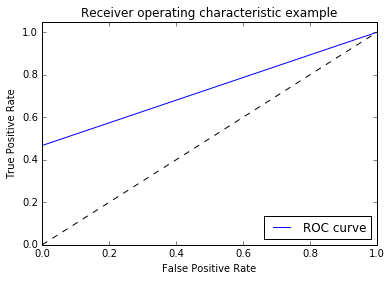

In [21]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])
#fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
display(preds.head())
fpr, tpr, thresholds = metrics.roc_curve(preds["actual"].values, preds["predictions"].values)
roc_auc = roc_auc_score(preds["actual"], preds["predictions"])
print(roc_auc)
print(fpr)
print(tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


# Optimize Features

Since STANDARD and HOME and AWAY Features got the best score going to optimize and minimize off of those features.

In [ ]:
def plot_RFECV(X, y):
    svc = SVC(kernel="linear")
    rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y, 2),
                  scoring='accuracy')
    rfecv.fit(X, y)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
plot_RFECV(ha_X, ha_y)

In [ ]:
def create_RFE(X, y):
    # Create the RFE object and rank each pixel
    svc = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=svc, n_features_to_select=1, step=1)
    rfe.fit(X, y)
    print(rfe.ranking_)
    return rfe.ranking_

(ha_y, ha_X) = model_libs._extract_target(ha_data, 'converted_goals')

# Taking all of Home/Away Data (even the Extended Features)
rankings = create_RFE(ha_X, ha_y)

In [ ]:
""" Reordering the columns in the data to reflect the rankings """

rankings_name = []
ranked_X = ha_X

for r in range(len(rankings)):
    column_name = ha_X.iloc[:, rankings[r]-1].name
    rankings_name.append(column_name)

ranked_X = ranked_X.reindex_axis(rankings_name, axis=1)
display(ranked_X.head())

In [ ]:
def train_ranked_models(X, y):
    
    for x in xrange(10, 20):
        print('X :: {}'.format(x))
        ranked_models = train_models(round_number, X.iloc[:, 1:x], y, ['knn'])
    
train_ranked_models(ranked_X, ha_y)

In [ ]:
def plot_PCA(data, preds):
    
    pca = PCA(n_components=4)
    pca.fit(data)
    
    # Generate PCA results plot
    pca_results = rs.pca_results(data, pca)
    #print(pca_results)
    pca_data = pca.transform(data)
    
    # Create a DataFrame for the reduced data
    pca_data = pd.DataFrame(pca_data, columns = ['Dimension 1', 'Dimension 2', 'Dimension 3', 'Dimension 4'])
    plot_data = pd.concat([preds, pca_data], axis = 1)
    
    # Scatterplotting the transformed data if it's 2 Dimensions
    """fig, ax = plt.subplots(figsize = (14,8))
    cmap = cm.get_cmap('gist_rainbow')
    
    for i, cluster in plot_data.groupby('converted_goals'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', 
                     color = cmap((i)*1.0/(4)), label = 'Points %i'%(i), s=30);"""
    
    return pca, plot_data, pca_results

#(ha_y, ha_X) = model_libs._extract_target(ha_data, 'converted_goals') 

pca, pca_data, pca_results = plot_PCA(ha_X, ha_y)
#display(pca_data.head())

print(pca_data.shape)
# Runs models on PCA to see if there is a difference in the results
models = run_features(pca_data, [], 'converted_goals', ['knn'])
(pca_y, pca_X) = model_libs._extract_target(pca_data, 'converted_goals')
knn = models[0]
#preds = knn.predict(pca_X)

actual_y = pd.DataFrame(pca_y.values, columns=['actual'])
predictions = pd.DataFrame(knn.predict(pca_X), columns=['predictions'])
preds = pd.concat([predictions, actual_y], axis=1)
preds['diff'] = preds.apply(lambda r: model_libs.predictions_diff(r['predictions'], r['actual']), axis=1)
accuracy = np.divide(preds['diff'].sum(),float(len(preds['diff'])))
print(accuracy)


In [ ]:
display(pca_results)
print(type(pca_results))
print(pca_results[])

### Making Predictions on Expected Goals Final Selected Model

In [ ]:
(ha_y, ha_X) = model_libs._extract_target(ha_data, 'converted_goals')
knn = train_models(round_number, ha_X, ha_y, ['knn'])
actual_y = pd.DataFrame(ha_y.values, columns=['actual'])

predictions = pd.DataFrame(knn[0].predict(ha_X), columns=['expected_goal_category'])
preds = pd.concat([predictions, actual_y], axis=1)
preds['diff'] = preds.apply(lambda r: model_libs.predictions_diff(r['expected_goal_category'], r['actual']), axis=1)
accuracy = np.divide(preds['diff'].sum(),float(len(preds['diff'])))
print(accuracy)

======================================================================================================================

### RUNNING LINEAR REGRESSION on FEATURES

### Creating Regression Model independent from Classification (without the Classifier's input as a feature)

In [22]:
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split, cross_val_predict
from sklearn import linear_model
from sklearn import grid_search
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.cross_validation import cross_val_score

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)


display(regr_data.head())
combined_data = regr_data.copy()

combined_data["goal_predictions"] = predictions
# Drop the original RPI features and everything else
r_data = combined_data.drop(sub_cols + ignore_cols + ['round', 'converted_goals'] + ['rpi', 'opp_rpi'], axis=1)
display(r_data.head())

(regr_y, regr_X) = model_libs._extract_target(r_data, 'goals')
        
X_train, X_test, y_train, y_test = cross_validation.train_test_split(regr_X, regr_y, test_size=0.2, random_state=42)

lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)
#predicted = cross_val_predict(lin_regr, reg_X, reg_y, cv=10)
print('Coefficients: \n', lin_regr.coef_)
print("Residual sum of squares: %.2f"
      % np.mean((lin_regr.predict(X_test) - y_test) ** 2))

preds = pd.DataFrame(lin_regr.predict(X_test), columns=['predictions'])
preds['rounded'] = preds.loc[0:].apply(lambda r: np.round(r), axis=1)
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % lin_regr.score(X_test, preds['rounded']))
display(preds.head())
preds = pd.concat([preds, pd.DataFrame(y_test.as_matrix(), columns=['actual'])], axis = 1)
preds['correct'] = preds.apply(lambda r: model_libs.predictions_diff(r['rounded'], r['actual']), axis=1)
preds['correct_category'] = preds.apply(lambda r: model_libs.check_category(r['rounded'], r['actual']), axis=1)
#display(preds.head())
accuracy = np.divide(preds['correct'].sum(),float(len(preds['correct'])))
accuracy_category = np.divide(preds['correct_category'].sum(), float(len(preds['correct_category'])))
print('accuracy on X TEST')
print(accuracy)
print('accuracy_category on X TEST')
print(accuracy_category)


,match_id,team_id,team_name,opp_id,opp_name,scheduled,round,games_played,is_home,current_formation,avg_points,avg_goals_for,avg_goals_against,margin,goal_diff,goal_efficiency,win_percentage,sos,rpi,opp_avg_points,opp_avg_goals,opp_margin,opp_goal_efficiency,opp_win_percentage,opp_sos,opp_rpi,goals_op_ratio,ball_safe_op_ratio,goal_attempts_op_ratio,current_team_possession,current_team_attacks,current_team_dangerous_attacks,current_team_yellow_cards,current_team_corner_kicks,current_team_shots_on_target,current_team_shots_total,current_team_ball_safe,current_team_goal_attempts,current_team_saves,current_team_first_half_goals,current_team_sec_half_goals,current_team_goal_kicks,opp_team_possession,opp_team_attacks,opp_team_dangerous_attacks,opp_team_yellow_cards,opp_team_corner_kicks,opp_team_shots_on_target,opp_team_shots_total,opp_team_ball_safe,opp_team_goal_attempts,opp_team_saves,opp_team_first_half_goals,opp_team_sec_half_goals,opp_team_goal_kicks,goals,converted_goals,rpi_quartiled,opp_rpi_quartiled
0,249,21,FC Dallas,33,DC United,2016-03-26 21:30:00,4,3,0,4-2-3-1,2.000000,1.333333,1.666667,-0.333333,-1,0.117647,0.666667,0.619048,0.630952,1.000000,2.000000,0.666667,0.000000,0.714286,0.517544,0.477444,0.666667,0.759644,1.346154,50.333333,103.333333,60.666667,2.000000,6.666667,6.666667,11.666667,85.333333,11.666667,1.666667,0.333333,1.000000,5.666667,48.666667,113.666667,45.333333,1.000000,2.333333,5.333333,8.666667,112.333333,8.666667,4.333333,0.666667,1.333333,8.666667,3,1,1.0000,0.0000
1,255,21,FC Dallas,39,Columbus Crew,2016-04-03 01:00:00,5,3,1,4-4-2,2.000000,1.666667,1.666667,0.000000,0,0.333333,0.714286,0.383130,0.465919,0.333333,0.333333,-1.000000,0.000000,0.312500,0.487421,0.407233,5.000000,0.871166,1.391304,50.666667,112.000000,56.333333,2.333333,4.666667,5.666667,10.666667,94.666667,10.666667,1.666667,0.666667,1.000000,5.333333,47.666667,110.666667,60.000000,2.333333,4.333333,2.333333,7.666667,108.666667,7.666667,1.666667,0.000000,0.333333,9.000000,1,0,0.3333,0.0000
2,265,21,FC Dallas,32,San Jose Earthquakes,2016-04-10 01:00:00,6,3,1,4-4-2,2.333333,2.000000,0.333333,1.666667,5,0.052632,0.833333,0.452519,0.547723,0.333333,0.666667,-0.333333,0.166667,0.312500,0.441520,0.456140,3.000000,1.025090,1.406250,49.333333,113.000000,56.000000,2.000000,3.333333,6.333333,15.000000,95.333333,15.000000,3.000000,0.666667,1.333333,5.666667,54.000000,97.666667,57.000000,0.333333,6.000000,6.333333,10.666667,93.000000,10.666667,2.666667,0.333333,0.333333,9.000000,2,1,0.6666,0.0000
3,272,21,FC Dallas,30,Portland Timbers,2016-04-14 02:30:00,7,3,0,4-4-2,1.666667,2.000000,1.000000,1.000000,3,0.153846,0.687500,0.434392,0.497669,1.000000,1.333333,-0.666667,0.285714,0.357143,0.645906,0.573715,1.500000,0.957447,2.157895,51.333333,103.333333,48.333333,2.666667,5.000000,5.666667,13.666667,90.000000,13.666667,2.666667,1.000000,1.000000,5.333333,44.666667,90.666667,44.666667,2.000000,3.000000,3.666667,6.333333,94.000000,6.333333,2.666667,0.333333,1.000000,9.666667,3,1,0.6666,1.0000
4,282,21,FC Dallas,27,Sporting Kansas City,2016-04-17 23:00:00,7,3,1,4-4-2,1.666667,2.000000,1.000000,1.000000,3,0.153846,0.687500,0.434392,0.497669,0.000000,1.333333,-0.666667,0.285714,0.357143,0.490184,0.523888,1.500000,0.957447,2.157895,51.333333,103.333333,48.333333,2.666667,5.000000,5.666667,13.666667,90.000000,13.666667,2.666667,1.000000,1.000000,5.333333,44.666667,90.666667,44.666667,2.000000,3.000000,3.666667,6.333333,94.000000,6.333333,2.666667,0.333333,1.000000,9.666667,2,1,0.6666,0.6666


,is_home,avg_points,avg_goals_for,margin,goal_efficiency,opp_avg_points,opp_avg_goals,opp_margin,opp_goal_efficiency,goals_op_ratio,ball_safe_op_ratio,goal_attempts_op_ratio,current_team_possession,current_team_attacks,current_team_dangerous_attacks,current_team_shots_on_target,current_team_shots_total,current_team_ball_safe,current_team_goal_attempts,current_team_saves,current_team_goal_kicks,opp_team_possession,opp_team_attacks,opp_team_dangerous_attacks,opp_team_shots_on_target,opp_team_shots_total,opp_team_ball_safe,opp_team_goal_attempts,opp_team_saves,opp_team_goal_kicks,goals,rpi_quartiled,opp_rpi_quartiled,goal_predictions
0,0,2.000000,1.333333,-0.333333,0.117647,1.000000,2.000000,0.666667,0.000000,0.666667,0.759644,1.346154,50.333333,103.333333,60.666667,6.666667,11.666667,85.333333,11.666667,1.666667,5.666667,48.666667,113.666667,45.333333,5.333333,8.666667,112.333333,8.666667,4.333333,8.666667,3,1.0000,0.0000,1
1,1,2.000000,1.666667,0.000000,0.333333,0.333333,0.333333,-1.000000,0.000000,5.000000,0.871166,1.391304,50.666667,112.000000,56.333333,5.666667,10.666667,94.666667,10.666667,1.666667,5.333333,47.666667,110.666667,60.000000,2.333333,7.666667,108.666667,7.666667,1.666667,9.000000,1,0.3333,0.0000,0
2,1,2.333333,2.000000,1.666667,0.052632,0.333333,0.666667,-0.333333,0.166667,3.000000,1.025090,1.406250,49.333333,113.000000,56.000000,6.333333,15.000000,95.333333,15.000000,3.000000,5.666667,54.000000,97.666667,57.000000,6.333333,10.666667,93.000000,10.666667,2.666667,9.000000,2,0.6666,0.0000,1
3,0,1.666667,2.000000,1.000000,0.153846,1.000000,1.333333,-0.666667,0.285714,1.500000,0.957447,2.157895,51.333333,103.333333,48.333333,5.666667,13.666667,90.000000,13.666667,2.666667,5.333333,44.666667,90.666667,44.666667,3.666667,6.333333,94.000000,6.333333,2.666667,9.666667,3,0.6666,1.0000,1
4,1,1.666667,2.000000,1.000000,0.153846,0.000000,1.333333,-0.666667,0.285714,1.500000,0.957447,2.157895,51.333333,103.333333,48.333333,5.666667,13.666667,90.000000,13.666667,2.666667,5.333333,44.666667,90.666667,44.666667,3.666667,6.333333,94.000000,6.333333,2.666667,9.666667,2,0.6666,0.6666,1


('Coefficients: \n', array([  3.54266852e-01,  -9.73885301e-02,   3.39747811e-02,
         1.36172675e-01,   3.69707819e-01,   1.18867370e-01,
        -1.42309755e-01,  -1.28206879e-02,   2.08118354e-01,
        -2.92331450e-02,   1.13933800e+00,  -4.39895618e-02,
         1.96261265e-02,  -1.14067045e-02,   1.34347362e-02,
        -4.63328977e-02,   4.59808475e-01,  -3.01002563e-03,
        -4.10113481e-01,  -8.58661158e-03,   1.48875488e-02,
         1.14909805e-03,  -4.46712739e-03,  -4.13355725e-03,
        -3.66455846e-02,   1.10909101e-01,   2.25238056e-02,
        -9.79445562e-02,  -4.50350697e-03,  -3.75595050e-02,
         1.26349072e-01,   1.58286884e-01,   1.35532902e+00]))
Residual sum of squares: 1.01
Variance score: 0.84


,predictions,rounded
0,1.702239,2
1,1.324550,1
2,1.138363,1
3,1.313548,1
4,0.764622,1


accuracy on X TEST
0.373983739837
accuracy_category on X TEST
0.813008130081


Predicting all goals on the regression model

In [19]:
#k_X = pd.DataFrame(k_X)

all_preds = pd.DataFrame(lin_regr.predict(regr_X), columns=['predictions'])
all_preds['rounded'] = all_preds.loc[0:].apply(lambda r: np.round(r), axis=1)

all_preds = pd.concat([regr_X, all_preds], axis = 1)

all_preds = pd.concat([all_preds, regr_data['goals']], axis=1)

necessary = all_preds[['predictions', 'rounded', 'goals']]
    
necessary['correct'] = necessary.apply(lambda r: model_libs.predictions_diff(r['rounded'], r['goals']), axis=1)
necessary['correct_category'] = necessary.apply(lambda r: model_libs.check_category(r['predictions'], r['goals']), axis=1)
display(necessary)

accuracy = np.divide(necessary['correct'].sum(),float(len(necessary['correct'])))
accuracy_category = np.divide(necessary['correct_category'].sum(), float(len(necessary['correct_category'])))

print('accuracy on All of X')
print(accuracy)
print('accuracy_category on All of X')
print(accuracy_category)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,predictions,rounded,goals,correct,correct_category
0,1.127779,1,3,0,0
1,1.745057,2,1,0,1
2,2.079661,2,2,1,1
3,2.005719,2,3,0,1
4,2.124778,2,2,1,1
5,1.326641,1,0,0,1
6,1.236433,1,0,0,1
7,0.827624,1,0,0,1
8,1.207837,1,2,0,0
9,1.333517,1,2,0,0


accuracy on All of X
0.325732899023
accuracy_category on All of X
0.614006514658
